# Loading the data

https://www.kaggle.com/datasets/mengcius/cinic10/data

In [1]:
import torch
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
import seaborn as sns
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
simple_load = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
])

In [4]:
train_dataset = ImageFolder('data/train', transform=simple_load)
val_dataset = ImageFolder('data/valid', transform=simple_load)

In [5]:
def get_image(path: str):
    image = torchvision.io.read_image(path)
    return v2.ToPILImage()(image)

def get_image_resized(path: str):
    image = get_image(path)
    resize = v2.Resize((128, 128))
    bigger_image = resize(image)

    return v2.ToPILImage()(bigger_image)

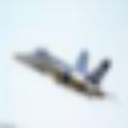

In [6]:
path = './data/train/airplane/cifar10-train-10008.png'
get_image_resized(path)

# 1. Network architectures

Custom CNN

In [7]:
class CustomCNN(nn.Module):

    def __init__(self, n_classes: int, dropout_prob: float = 0.0):
        super(CustomCNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(48 * 5 * 5, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(256, n_classes),
            nn.Softmax(dim=1),
        )
        self.to(device)

    def forward(self, obs) -> torch.Tensor:
        return self.network(obs)

Resnet-18 not pretrained (random weights)

In [8]:
def get_resnet(n_classes: int):
    model_resnet = models.resnet18(pretrained=False)

    output_features = model_resnet.fc.in_features 
    ## We have 512 output features, we have to add to model a fully connected layer for our classification problem with only 10 target classes
    model_resnet.fc = nn.Linear(output_features, n_classes)
    model_resnet = model_resnet.to(device)
    return model_resnet

Resnet-18 pretrained

In [9]:
def get_resnet_pretrained(n_classes: int):
    model_resnet_pretrained = models.resnet18(pretrained=True)

    ## freezing all pretrain layers
    for param in model_resnet_pretrained.parameters():
        param.requires_grad = False

    output_features = model_resnet_pretrained.fc.in_features 
    ## We have 512 output features, we have to add to model a fully connected layer for our classification problem with only 10 target classes
    model_resnet_pretrained.fc = nn.Linear(output_features, n_classes)
    model_resnet_pretrained = model_resnet_pretrained.to(device)
    return model_resnet_pretrained

Train function

In [10]:
import os
import json
from datetime import datetime

In [11]:
def train(network: nn.Module, train_dataset: ImageFolder, valid_dataset: ImageFolder, batch_size: int,
          loss_fn, optimizer: torch.optim.Optimizer, max_epochs: int, advanced_augmentations=None, 
          save_name: str | None = None, verbosity_period=1) -> dict[str, list[float]]:
    """
    Based on: https://alirezasamar.com/blog/2023/03/fine-tuning-pre-trained-resnet-18-model-image-classification-pytorch/

    Returns:
        training statstics
    """
    train_loss_per_epoch: list[float] = []
    train_accuracy_per_epoch: list[float] = []
    valid_loss_per_epoch: list[float] = []
    valid_accuracy_per_epoch: list[float] = []

    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(max_epochs):
        epoch = epoch + 1

        # setup for training
        network.train()
        train_epoch_loss_sum = 0.0
        train_epoch_true_count = 0

        # training loop
        for images, true_labels in train_data_loader:
            # apply advanced augmentations (if specified)
            if advanced_augmentations is not None:
                images, true_labels = advanced_augmentations(images, true_labels)

            # move to the device (especially necessary when using cuda)
            images = images.to(device)
            true_labels = true_labels.to(device)

            # feed forward
            optimizer.zero_grad()
            pred_proba = network(images)
            loss = loss_fn(pred_proba, true_labels)
            # backpropagation and update weights
            loss.backward()
            optimizer.step()

            # update current epoch's stats
            train_epoch_loss_sum += loss.item() * images.size(0)
            # calculate accuracy but only if no advanced augmentations are used
            # this is because with advanced augmentations true_labels becomes
            # probabilites of each class
            if advanced_augmentations is None:
                pred_labels = torch.argmax(pred_proba, dim=1)
                train_epoch_true_count += torch.sum(pred_labels == true_labels.data)

        # calculate and update stats
        curr_train_loss = float(train_epoch_loss_sum / len(train_dataset))
        train_loss_per_epoch.append(curr_train_loss)
        if advanced_augmentations is None:
            curr_train_accuracy = float(train_epoch_true_count.double() / len(train_dataset))
            train_accuracy_per_epoch.append(curr_train_accuracy)

        # setup for validation
        network.eval()
        valid_epoch_loss_sum = 0.0
        valid_epoch_true_count = 0

        with torch.no_grad():
            # same as before but on validation data
            for images, true_labels in valid_data_loader:
                # move to device
                images = images.to(device)
                true_labels = true_labels.to(device)

                # make a prediction
                pred_proba = network(images)
                pred_labels = torch.argmax(pred_proba, dim=1)
                loss = loss_fn(pred_proba, true_labels)

                # update stats
                valid_epoch_loss_sum += loss.item() * images.size(0)
                valid_epoch_true_count += torch.sum(pred_labels == true_labels.data)

        # calculate and update stats
        curr_valid_loss = float(valid_epoch_loss_sum / len(val_dataset))
        curr_valid_acccuracy = float(valid_epoch_true_count.double() / len(val_dataset))
        valid_loss_per_epoch.append(curr_valid_loss)
        valid_accuracy_per_epoch.append(curr_valid_acccuracy)

        # Verbosity
        if  verbosity_period > 0 and epoch % verbosity_period == 0:
            train_acc_text = ''
            if advanced_augmentations is None:
                train_acc_text = f'Train accuracy: {curr_train_accuracy:.4f} | '
            print(f'Epoch {epoch} completed! | '
                  f'Train loss: {curr_train_loss:.4f} | '
                  f'{train_acc_text}'
                  f'Validation loss: {curr_valid_loss:.4f} | '
                  f'Validation accuracy: {curr_valid_acccuracy:.4f}')

    stats = {
        'train_loss': train_loss_per_epoch,
        'train_accuracy': train_accuracy_per_epoch,
        'valid_loss': valid_loss_per_epoch,
        'valid_accuracy': valid_accuracy_per_epoch,
    }

    # save network weights and stats at the end
    if save_name is not None:
        # prepare save dir
        datetime_id = datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
        save_dir = os.path.join('.', 'saved', f'{save_name}_{datetime_id}')
        os.makedirs(save_dir, exist_ok=True)
        # save network weights
        model_path = os.path.join(save_dir, f'{save_name}.pth')
        torch.save(network.state_dict(), model_path)
        # save training stats
        stats_path = os.path.join(save_dir, f'{save_name}.json')
        with open(stats_path, 'w') as file:
            json.dump(stats, file)
    
    return stats

In [12]:
def load_weights(network_fresh: nn.Module, path: str) -> None:
    """Loads saved weights to the given network"""
    network_fresh.load_state_dict(torch.load(path, map_location=torch.device(device)))
    network_fresh.eval()

In [13]:
def load_stats(path: str) -> dict[str, list[float]]:
    with open(path) as file:
        stats = json.load(file)
    return stats

## Training

For now, hyperparameters are identical for each network to allow a fair comparison. Hyperparameters will be tuned later.

### Custom CNN

In [236]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

model_custom = CustomCNN(10)

stats_custom = train(
    model_custom, train_dataset, val_dataset, 
    batch_size=128, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.SGD(model_custom.parameters(), lr=0.001, momentum=0.9), 
    max_epochs=50,
    save_name='architectures_custom',
    verbosity_period = 0
)

In [218]:
# Load saved model & stats from the previous cell
model_custom = CustomCNN(10)
load_weights(model_custom, './saved/architectures_custom/architectures_custom.pth')
stats_custom = load_stats('./saved/architectures_custom/architectures_custom.json')

### Resnet with random weights

In [1]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

model_resnet = get_resnet(10)

stats_resnet = train(
    model_resnet, train_dataset, val_dataset, 
    batch_size=128, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9), 
    max_epochs=50,
    save_name='architectures_resnet',
)

In [219]:
# Load saved model & stats from the previous cell
model_resnet = get_resnet(10)
load_weights(model_resnet, './saved/architectures_resnet/architectures_resnet.pth')
stats_resnet = load_stats('./saved/architectures_resnet/architectures_resnet.json')

### Resnet pretrained

In [4]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

model_resnet_pretrained = get_resnet_pretrained(10)

criterion = nn.CrossEntropyLoss()
# train the final added layer for a few epochs, with pre-trained layers frozen
train(
    model_resnet_pretrained, train_dataset, val_dataset, 
    batch_size=128, 
    loss_fn=criterion, 
    optimizer=optim.SGD(model_resnet_pretrained.parameters(), lr=0.0001, momentum=0.9), 
    max_epochs=10,
)

# unfreeze all the layers and fine-tune the entire network for more epochs
for param in model_resnet_pretrained.parameters():
    param.requires_grad = True

stats_resnet_pretrained = train(
    model_resnet_pretrained, train_dataset, val_dataset, 
    batch_size=128, 
    loss_fn=criterion, 
    optimizer=torch.optim.SGD(model_resnet_pretrained.parameters(), lr=0.001, momentum=0.9), 
    max_epochs=40, 
    save_name='architectures_resnet_pretrained',
)

In [220]:
# Load saved model & stats from the previous cell
model_resnet_pretrained = get_resnet_pretrained(10)
load_weights(model_resnet_pretrained, './saved/architectures_resnet_pretrained/architectures_resnet_pretrained.pth')
stats_resnet_pretrained = load_stats('./saved/architectures_resnet_pretrained/architectures_resnet_pretrained.json')

### Results 

In [226]:
for name, stats in zip(['Custom', 'ResNet-18', 'ResNet-18 pre-trained'], [stats_custom, stats_resnet, stats_resnet_pretrained]):
    print(name)
    print(f'Train acc: {stats["train_accuracy"][-1]:.3f}')
    print(f'Train acc: {stats["valid_accuracy"][-1]:.3f}')

Custom
Train acc: 0.720
Train acc: 0.550
ResNet-18
Train acc: 0.983
Train acc: 0.527
ResNet-18 pre-trained
Train acc: 0.988
Train acc: 0.656


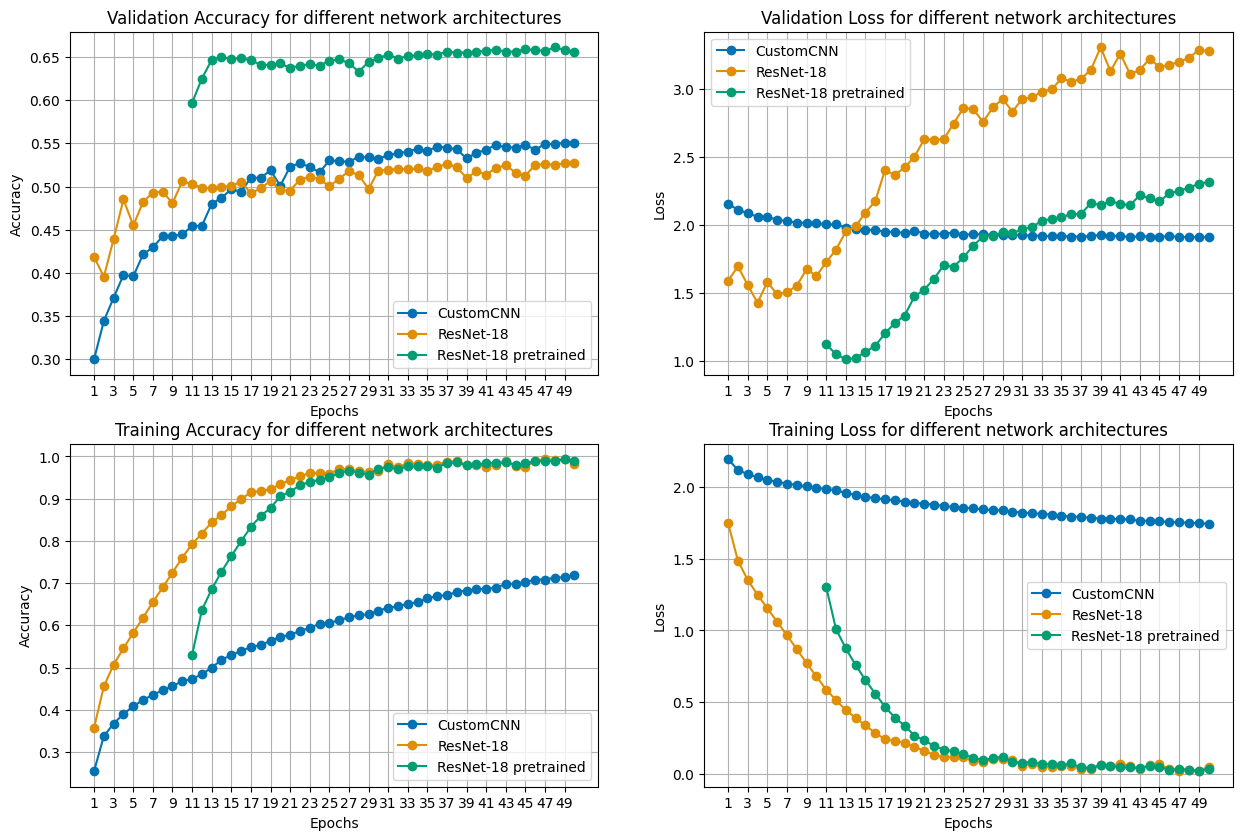

In [17]:
x_vals = list(range(1, len(stats_custom['valid_accuracy']) + 1))
x_vals_r_pretrained = list(range(11, len(stats_custom['valid_accuracy']) + 1))

x_ticks = list(range(1, len(stats_custom['valid_accuracy']) + 1, 2))

plt.figure(figsize=(15, 10), dpi=100)
sns.set_palette("colorblind")

# Plot valid accuracy
plt.subplot(2, 2, 1)
plt.plot(x_vals, stats_custom['valid_accuracy'], label='CustomCNN', marker='o')
plt.plot(x_vals, stats_resnet['valid_accuracy'], label='ResNet-18', marker='o')
plt.plot(x_vals_r_pretrained, stats_resnet_pretrained['valid_accuracy'], label='ResNet-18 pretrained', marker='o')
plt.title('Validation Accuracy for different network architectures')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(x_ticks)
plt.grid(True)

# Plot valid loss
plt.subplot(2, 2, 2)
plt.plot(x_vals, stats_custom['valid_loss'], label='CustomCNN', marker='o')
plt.plot(x_vals, stats_resnet['valid_loss'], label='ResNet-18', marker='o')
plt.plot(x_vals_r_pretrained, stats_resnet_pretrained['valid_loss'], label='ResNet-18 pretrained', marker='o')
plt.title('Validation Loss for different network architectures')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(x_ticks)
plt.grid(True)

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(x_vals, stats_custom['train_accuracy'], label='CustomCNN', marker='o')
plt.plot(x_vals, stats_resnet['train_accuracy'], label='ResNet-18', marker='o')
plt.plot(x_vals_r_pretrained, stats_resnet_pretrained['train_accuracy'], label='ResNet-18 pretrained', marker='o')
plt.title('Training Accuracy for different network architectures')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(x_ticks)
plt.grid(True)

# Plot train loss
plt.subplot(2, 2, 4)
plt.plot(x_vals, stats_custom['train_loss'], label='CustomCNN', marker='o')
plt.plot(x_vals, stats_resnet['train_loss'], label='ResNet-18', marker='o')
plt.plot(x_vals_r_pretrained, stats_resnet_pretrained['train_loss'], label='ResNet-18 pretrained', marker='o')
plt.title('Training Loss for different network architectures')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(x_ticks)
plt.grid(True)

plt.show()

# 2. Augmentations

In [18]:
def get_augmentated_image(path: str, augmentation):
    image = get_image(path)
    image = augmentation(image)
    resize = v2.Resize((128, 128))
    bigger_image = resize(image)

    return v2.ToPILImage()(bigger_image)

Simple: flipping, rotation, crop image and resize to original size, change colours

In [19]:
data_augmentations_simple = v2.Compose([
    v2.RandomResizedCrop(size=(32, 32)),
    v2.RandomRotation(degrees=(0, 180)),
    v2.RandomHorizontalFlip(p=0.2),
    v2.RandomInvert(p=0.2),
    v2.RandomSolarize(p=0.2, threshold=100),
])

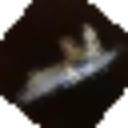

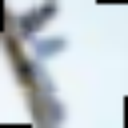

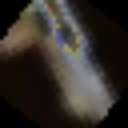

In [20]:
from IPython.display import display
path = './data/train/airplane/cifar10-train-10008.png'

for i in range(3):
    display(get_augmentated_image(path, data_augmentations_simple))

In [21]:
data_loading_pipeline_simple = v2.Compose([
    data_augmentations_simple,
    simple_load,  
])

Advanced: Randomly CutMix or MixUp

In [22]:
data_augmentations_advanced = v2.Compose([
    v2.RandomChoice([
        v2.CutMix(num_classes=10), 
        v2.MixUp(num_classes=10),
    ])
])

### Testing simple augmentations 

In [103]:
train_dataset = ImageFolder('data/train', transform=data_loading_pipeline_simple)
val_dataset = ImageFolder('data/valid', transform=data_loading_pipeline_simple)

In [5]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_augm_simple = get_resnet(10)

stats_augm_simple = train(
    model_augm_simple, train_dataset, val_dataset, 
    batch_size=128, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.SGD(model_augm_simple.parameters(), lr=0.001, momentum=0.9), 
    max_epochs=30, 
    save_name='augmentations_simple',
)

In [23]:
# Load saved model & stats from the previous cell
model_augm_simple = get_resnet(10)
load_weights(model_augm_simple, './saved/augmentations_simple/augmentations_simple.pth')
stats_augm_simple = load_stats('./saved/augmentations_simple/augmentations_simple.json')

### Testing Advanced Augmentations

In [105]:
train_dataset = ImageFolder('data/train', transform=simple_load)
val_dataset = ImageFolder('data/valid', transform=simple_load)

In [6]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_augm_advanced = get_resnet(10)

stats_augm_advanced = train(
    model_augm_advanced, train_dataset, val_dataset, 
    batch_size=128, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.SGD(model_augm_advanced.parameters(), lr=0.001, momentum=0.9), 
    max_epochs=30, 
    advanced_augmentations=data_augmentations_advanced, 
    save_name='augmentations_advanced',
)

In [24]:
# Load saved model & stats from the previous cell
model_augm_advanced = get_resnet(10)
load_weights(model_augm_advanced, './saved/augmentations_advanced/augmentations_advanced.pth')
stats_augm_advanced = load_stats('./saved/augmentations_advanced/augmentations_advanced.json')

### Testing all augmentations 

In [107]:
train_dataset = ImageFolder('data/train', transform=data_loading_pipeline_simple)
val_dataset = ImageFolder('data/valid', transform=data_loading_pipeline_simple)

In [7]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_augm_all = get_resnet(10)

stats_augm_all = train(
    model_augm_all, train_dataset, val_dataset, 
    batch_size=128, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.SGD(model_augm_all.parameters(), lr=0.001, momentum=0.9), 
    max_epochs=30, 
    advanced_augmentations=data_augmentations_advanced, 
    save_name='augmentations_all',
)

In [25]:
# Load saved model & stats from the previous cell
model_augm_all = get_resnet(10)
load_weights(model_augm_all, './saved/augmentations_all/augmentations_all.pth')
stats_augm_all = load_stats('./saved/augmentations_all/augmentations_all.json')

### Results

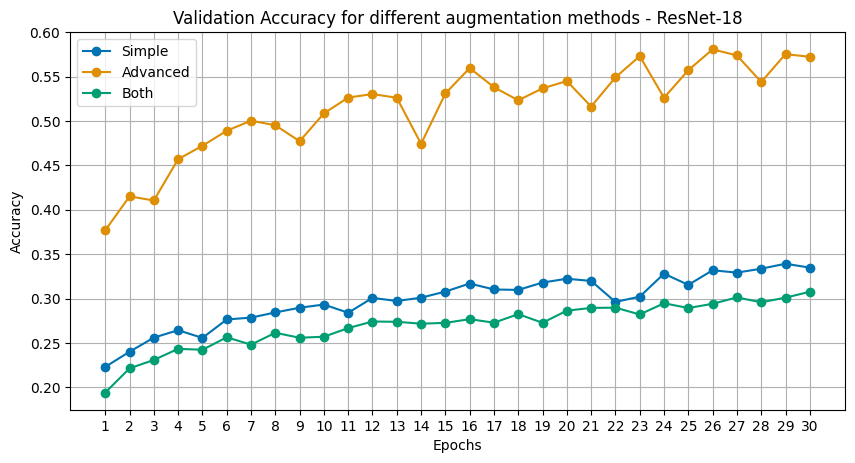

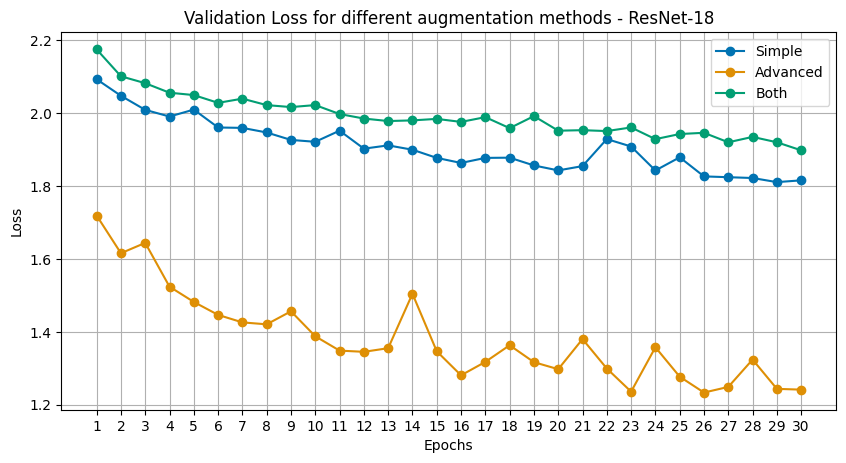

In [26]:
x_vals = list(range(1, len(stats_augm_all['valid_accuracy']) + 1))

# Plot accuracy
sns.set_palette("colorblind")
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(x_vals, stats_augm_simple['valid_accuracy'], label='Simple', marker='o')
plt.plot(x_vals, stats_augm_advanced['valid_accuracy'], label='Advanced', marker='o')
plt.plot(x_vals, stats_augm_all['valid_accuracy'], label='Both', marker='o')
plt.title('Validation Accuracy for different augmentation methods - ResNet-18')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(x_vals)
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(x_vals, stats_augm_simple['valid_loss'], label='Simple', marker='o')
plt.plot(x_vals, stats_augm_advanced['valid_loss'], label='Advanced', marker='o')
plt.plot(x_vals, stats_augm_all['valid_loss'], label='Both', marker='o')
plt.title('Validation Loss for different augmentation methods - ResNet-18')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(x_vals)
plt.grid(True)
plt.show()

## Alternative simple augmentations

We have decided to reduce the number of augmentations, hoping it would improve the results

In [27]:
data_augmentations_simple_alt = v2.Compose([
    v2.RandomRotation(degrees=(0, 180)),
    v2.RandomHorizontalFlip(p=0.2),
])

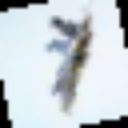

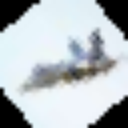

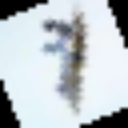

In [28]:
from IPython.display import display
path = './data/train/airplane/cifar10-train-10008.png'

for i in range(3):
    display(get_augmentated_image(path, data_augmentations_simple_alt))

In [29]:
data_loading_pipeline_simple_alt = v2.Compose([
    data_augmentations_simple_alt,
    simple_load,  
])

### Testing alternative simple augmentations 

In [30]:
train_dataset = ImageFolder('data/train', transform=data_loading_pipeline_simple_alt)
val_dataset = ImageFolder('data/valid', transform=data_loading_pipeline_simple_alt)

In [8]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_augm_simple_alt = get_resnet(10)

stats_augm_simple_alt = train(
    model_augm_simple_alt, train_dataset, val_dataset, 
    batch_size=128, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.SGD(model_augm_simple_alt.parameters(), lr=0.001, momentum=0.9), 
    max_epochs=30, 
    save_name='augmentations_simple_alt',
)

In [31]:
# Load saved model & stats from the previous cell
model_augm_simple_alt = get_resnet(10)
load_weights(model_augm_simple_alt, './saved/augmentations_simple_alt/augmentations_simple_alt.pth')
stats_augm_simple_alt = load_stats('./saved/augmentations_simple_alt/augmentations_simple_alt.json')

### Testing all augmentations (alternative simple + advanced)

In [117]:
train_dataset = ImageFolder('data/train', transform=data_loading_pipeline_simple_alt)
val_dataset = ImageFolder('data/valid', transform=data_loading_pipeline_simple_alt)

In [9]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_augm_all_alt = get_resnet(10)

stats_augm_all_alt = train(
    model_augm_all_alt, train_dataset, val_dataset, 
    batch_size=128, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.SGD(model_augm_all_alt.parameters(), lr=0.001, momentum=0.9), 
    max_epochs=30, 
    advanced_augmentations=data_augmentations_advanced, 
    save_name='augmentations_all_alt',
)

In [32]:
# Load saved model & stats from the previous cell
model_augm_all_alt = get_resnet(10)
load_weights(model_augm_all_alt, './saved/augmentations_all_alt/augmentations_all_alt.pth')
stats_augm_all_alt = load_stats('./saved/augmentations_all_alt/augmentations_all_alt.json')

### Results

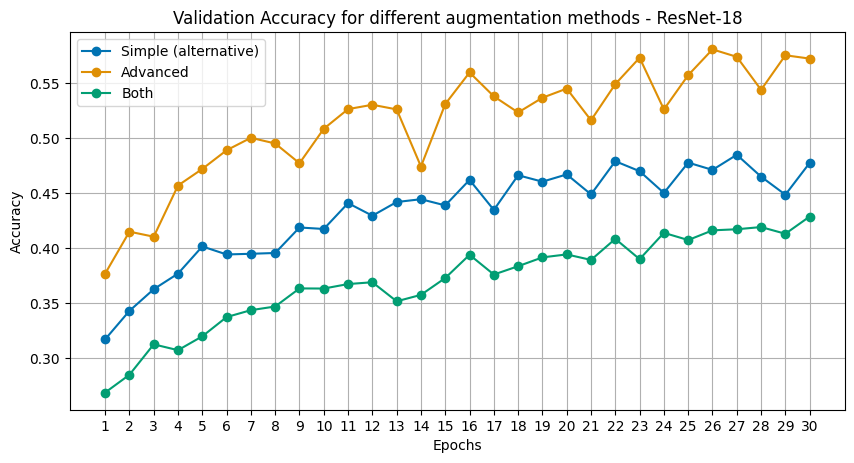

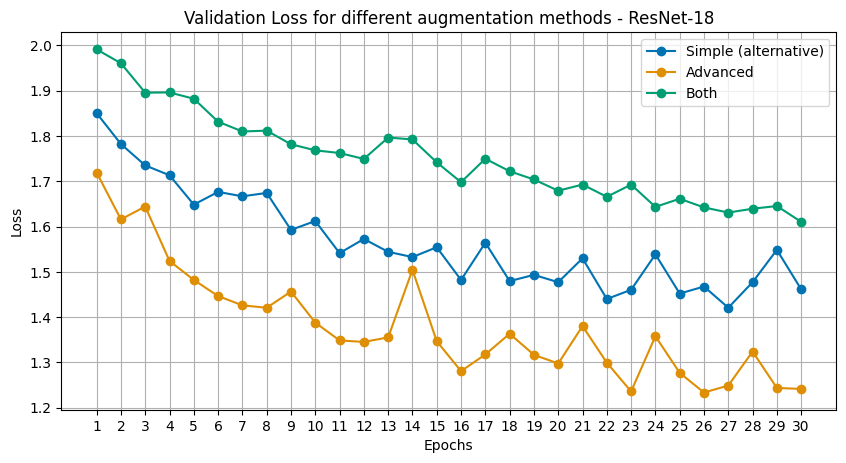

In [33]:
x_vals = list(range(1, len(stats_augm_all_alt['valid_accuracy']) + 1))

# Plot accuracy
sns.set_palette("colorblind")
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(x_vals, stats_augm_simple_alt['valid_accuracy'], label='Simple (alternative)', marker='o')
plt.plot(x_vals, stats_augm_advanced['valid_accuracy'], label='Advanced', marker='o')
plt.plot(x_vals, stats_augm_all_alt['valid_accuracy'], label='Both', marker='o')
plt.title('Validation Accuracy for different augmentation methods - ResNet-18')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(x_vals)
plt.grid(True)  # Add grid
plt.show()

# Plot loss
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(x_vals, stats_augm_simple_alt['valid_loss'], label='Simple (alternative)', marker='o')
plt.plot(x_vals, stats_augm_advanced['valid_loss'], label='Advanced', marker='o')
plt.plot(x_vals, stats_augm_all_alt['valid_loss'], label='Both', marker='o')
plt.title('Validation Loss for different augmentation methods - ResNet-18')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(x_vals)
plt.grid(True)  # Add grid
plt.show()

# 3. Hyperparameters

To select the best hyperparameters we use Bayes optimization. We test separately for diffrenet network weights optimizers (SGD, Adam, RMSprop).

In [35]:
from typing import Any

from bayes_opt import BayesianOptimization

We will use advanced augmentation since it produced the best results in the previous experiment

In [19]:
train_dataset = ImageFolder('data/train', transform=simple_load)
val_dataset = ImageFolder('data/valid', transform=simple_load)

In [36]:
def save_bayes_result(path: str, best_params: dict[str, Any], best_accuracy: float):
    data = {
        'best_params': best_params,
        'best_accuracy': best_accuracy,
    }
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, 'w') as file:
        json.dump(data, file)


def load_bayes_result(path: str) -> tuple[dict[str, Any], float]:
    with open(path, 'r') as file:
        data = json.load(file)
    return data['best_params'], data['best_accuracy']

### CustomCNN - optimized parameters

For SGD:

In [127]:
def objective_function_customcnn_sgd(batch_size_exp, learning_rate, l2_reg, dropout, momentum):
    batch_size = 2**int(batch_size_exp)
    model = CustomCNN(10, dropout_prob=dropout)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_reg, momentum=momentum)

    stats = train(model, train_dataset, val_dataset, batch_size, criterion, optimizer, 
                  advanced_augmentations=data_augmentations_advanced, max_epochs=15, verbosity_period=0)
    val_acc = stats['valid_accuracy'][-1]
    return val_acc

In [128]:
pbounds = {
    'dropout': (0, 0.2),
    'batch_size_exp': (5, 10),  # will be rounded down so from 5 to 9, making batch size from 32 to 512
    'learning_rate': (1e-4, 0.01),
    'l2_reg': (1e-5, 0.01),
    'momentum': (0.0, 0.99)
}
optimizer = BayesianOptimization(
    f=objective_function_customcnn_sgd,
    pbounds=pbounds,
    random_state=42
)
optimizer.maximize(
    init_points=4,
    n_iter=10
)
best_hyperparams_customcnn_sgd = optimizer.max['params']
accuracy_customcnn_sgd = optimizer.max['target']
save_bayes_result('./saved/bayes/customcnn_sgd.json', best_hyperparams_customcnn_sgd, accuracy_customcnn_sgd)

|   iter    |  target   | batch_... |  dropout  |  l2_reg   | learni... | momentum  |
-------------------------------------------------------------------------------------
| 1         | 0.3177    | 6.873     | 0.1901    | 0.007323  | 0.006027  | 0.1545    |
| 2         | 0.2744    | 5.78      | 0.01162   | 0.008663  | 0.006051  | 0.701     |
| 3         | 0.3191    | 5.103     | 0.194     | 0.008326  | 0.002202  | 0.18      |
| 4         | 0.3402    | 5.917     | 0.06085   | 0.005252  | 0.004376  | 0.2883    |
| 5         | 0.3182    | 6.936     | 0.1382    | 0.002588  | 0.008337  | 0.6037    |
| 6         | 0.3157    | 9.532     | 0.02107   | 0.001481  | 0.00926   | 0.763     |
| 7         | 0.2487    | 7.92      | 0.009557  | 0.0003677 | 0.001135  | 0.2309    |
| 8         | 0.3128    | 7.343     | 0.1986    | 0.009219  | 0.004375  | 0.3124    |
| 9         | 0.3059    | 9.038     | 0.03516   | 0.003174  | 0.002762  | 0.7186    |
| 10        | 0.32      | 7.456     | 0.05114   | 0.00

For Adam:

In [130]:
def objective_function_customcnn_adam(batch_size_exp, learning_rate, l2_reg, dropout, beta1, beta2):
    batch_size = 2**int(batch_size_exp)
    model = CustomCNN(10, dropout_prob=dropout)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg, betas=(beta1, beta2))

    stats = train(model, train_dataset, val_dataset, batch_size, criterion, optimizer, 
                  advanced_augmentations=data_augmentations_advanced, max_epochs=15, verbosity_period=0)
    val_acc = stats['valid_accuracy'][-1]
    return val_acc

In [131]:
pbounds = {
    'dropout': (0, 0.2),
    'batch_size_exp': (5, 10),  # will be rounded down so from 5 to 9, making batch size from 32 to 512
    'learning_rate': (1e-4, 0.01),
    'l2_reg': (1e-5, 0.01),
    'beta1': (0.0, 0.99),
    'beta2': (0.0, 0.99)
}
optimizer = BayesianOptimization(
    f=objective_function_customcnn_adam,
    pbounds=pbounds,
    random_state=42
)
optimizer.maximize(
    init_points=4,
    n_iter=10
)
best_hyperparams_customcnn = optimizer.max['params']
accuracy_customcnn = optimizer.max['target']
save_bayes_result('./saved/bayes/customcnn_adam.json', best_hyperparams_customcnn, accuracy_customcnn)

|   iter    |  target   | batch_... |   beta1   |   beta2   |  dropout  |  l2_reg   | learni... |
-------------------------------------------------------------------------------------------------


| 1         | 0.2815    | 6.873     | 0.9412    | 0.7247    | 0.1197    | 0.001569  | 0.001644  |
| 2         | 0.1       | 5.29      | 0.8575    | 0.5951    | 0.1416    | 0.0002156 | 0.009702  |
| 3         | 0.1       | 9.162     | 0.2102    | 0.18      | 0.03668   | 0.003049  | 0.005295  |
| 4         | 0.1       | 7.16      | 0.2883    | 0.6057    | 0.0279    | 0.002929  | 0.003727  |
| 5         | 0.1       | 8.768     | 0.849     | 0.5842    | 0.07327   | 0.004415  | 0.007884  |
| 6         | 0.1       | 5.621     | 0.7056    | 0.7333    | 0.03128   | 0.006342  | 0.00886   |
| 7         | 0.3688    | 6.72      | 0.99      | 0.847     | 0.2       | 3.672e-05 | 0.0001    |
| 8         | 0.1       | 8.948     | 0.5302    | 0.8858    | 0.09147   | 0.00423   | 0.006573  |
| 9         | 0.4052    | 6.415     | 0.99      | 0.99      | 0.2       | 1e-05     | 0.0001    |
| 10        | 0.3609    | 6.372     | 0.99      | 0.5303    | 0.2       | 1e-05     | 0.0001    |
| 11        | 0.1   

### ResNet-18 - optimized parameters

For SGD:

In [135]:
def objective_function_resnet_sgd(batch_size_exp, learning_rate, l2_reg, momentum):
    batch_size = 2**int(batch_size_exp)
    model = get_resnet(10)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_reg, momentum=momentum)

    stats = train(model, train_dataset, val_dataset, batch_size, criterion, optimizer, 
                  advanced_augmentations=data_augmentations_advanced, max_epochs=15, verbosity_period=0)
    val_acc = stats['valid_accuracy'][-1]
    return val_acc

In [136]:
pbounds = {
    'batch_size_exp': (5, 10),  # will be rounded down so from 5 to 9, making batch size from 32 to 512
    'learning_rate': (1e-4, 0.01),
    'l2_reg': (1e-5, 0.01),
    'momentum': (0.0, 0.99)
}
optimizer = BayesianOptimization(
    f=objective_function_resnet_sgd,
    pbounds=pbounds,
    random_state=42
)
optimizer.maximize(
    init_points=4,
    n_iter=10
)
best_hyperparams_resnet_sgd = optimizer.max['params']
accuracy_resnet_sgd = optimizer.max['target']
save_bayes_result('./saved/bayes/resnet_sgd.json', best_hyperparams_resnet_sgd, accuracy_resnet_sgd)

|   iter    |  target   | batch_... |  l2_reg   | learni... | momentum  |
-------------------------------------------------------------------------


| 1         | 0.3307    | 6.873     | 0.009508  | 0.007347  | 0.5927    |
| 2         | 0.4401    | 5.78      | 0.001568  | 0.000675  | 0.8575    |
| 3         | 0.3657    | 8.006     | 0.007084  | 0.0003038 | 0.9602    |
| 4         | 0.3207    | 9.162     | 0.002131  | 0.0019    | 0.1816    |
| 5         | 0.4254    | 5.756     | 0.001331  | 0.008918  | 0.8888    |
| 6         | 0.3583    | 5.814     | 0.002562  | 0.009908  | 0.6661    |
| 7         | 0.4006    | 5.773     | 0.00453   | 0.00319   | 0.8568    |
| 8         | 0.4244    | 5.797     | 0.003214  | 0.00415   | 0.856     |
| 9         | 0.3427    | 5.784     | 0.004214  | 0.008121  | 0.8739    |
| 10        | 0.461     | 5.789     | 0.001746  | 0.003338  | 0.8547    |
| 11        | 0.4599    | 5.788     | 0.001659  | 0.003017  | 0.8608    |
| 12        | 0.4013    | 5.968     | 0.006216  | 0.002558  | 0.7601    |
| 13        | 0.3731    | 5.032     | 0.004598  | 0.009769  | 0.5215    |
| 14        | 0.3624    | 5.743     | 

For Adam:

In [138]:
def objective_function_resnet_adam(batch_size_exp, learning_rate, l2_reg, beta1, beta2):
    batch_size = 2**int(batch_size_exp)
    model = get_resnet(10)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg, betas=(beta1, beta2))

    stats = train(model, train_dataset, val_dataset, batch_size, criterion, optimizer, 
                  advanced_augmentations=data_augmentations_advanced, max_epochs=15, verbosity_period=0)
    val_acc = stats['valid_accuracy'][-1]
    return val_acc

In [139]:
pbounds = {
    'batch_size_exp': (5, 10),  # will be rounded down so from 5 to 9, making batch size from 32 to 512
    'learning_rate': (1e-4, 0.01),
    'l2_reg': (1e-5, 0.01),
    'beta1': (0.0, 0.99),
    'beta2': (0.0, 0.99)
    
}
optimizer = BayesianOptimization(
    f=objective_function_resnet_adam,
    pbounds=pbounds,
    random_state=42
)
optimizer.maximize(
    init_points=4,
    n_iter=10
)
best_hyperparams_resnet_adam = optimizer.max['params']
accuracy_resnet_adam = optimizer.max['target']
save_bayes_result('./saved/bayes/resnet_adam.json', best_hyperparams_resnet_adam, accuracy_resnet_adam)

|   iter    |  target   | batch_... |   beta1   |   beta2   |  l2_reg   | learni... |
-------------------------------------------------------------------------------------
| 1         | 0.3037    | 6.873     | 0.9412    | 0.7247    | 0.005991  | 0.001645  |
| 2         | 0.1078    | 5.78      | 0.0575    | 0.8575    | 0.006015  | 0.00711   |
| 3         | 0.2769    | 5.103     | 0.9602    | 0.8241    | 0.002131  | 0.0019    |
| 4         | 0.2005    | 5.917     | 0.3012    | 0.5195    | 0.004325  | 0.002983  |
| 5         | 0.3377    | 6.896     | 0.99      | 0.77      | 0.005817  | 0.001639  |
| 6         | 0.3689    | 7.073     | 0.99      | 0.99      | 0.00445   | 0.001562  |
| 7         | 0.2215    | 7.442     | 0.99      | 0.7349    | 0.01      | 0.01      |
| 8         | 0.3529    | 6.525     | 0.9564    | 0.9888    | 0.007204  | 0.001495  |
| 9         | 0.4892    | 6.042     | 0.99      | 0.99      | 1e-05     | 0.0001    |
| 10        | 0.2717    | 5.964     | 0.9634    | 0.72

# 4. Training final models

Here we train final models based on the results in the previous experiments. Hence we use advanced augmentations, and the best parameters found through bayesian optimisation.

For Custom CNN, we use only Adam optimiser, as it helped produce a far better model than when SGD was used

For ResNet-18, we use both optimisers, since both produced similar results (Adam edging only slightly). Also since ResNet-18 performed better in general than CustomCNN, we decided it would be better to focus more on it and train two powerful models.

We also train the pre-trained ResNet-18 on the best ResNet hyperparameters with Adam, to compare it with other models. However, it will not be used for final evaluation on the test data

In [37]:
train_dataset = ImageFolder('data/train', transform=simple_load)
val_dataset = ImageFolder('data/valid', transform=simple_load)

## Custom CNN (with Adam)

In [38]:
best_hyperparams_customcnn, accuracy_customcnn = load_bayes_result('./saved/bayes/customcnn_adam.json')

In [149]:
torch.manual_seed(24)
torch.cuda.manual_seed(24)

best_batch_size_exp = int(best_hyperparams_customcnn['batch_size_exp'])
best_learning_rate = best_hyperparams_customcnn['learning_rate']
best_l2_reg = best_hyperparams_customcnn['l2_reg']
best_beta1 = best_hyperparams_customcnn['beta1']
best_beta2 = best_hyperparams_customcnn['beta2']

model_best_custom = CustomCNN(10)
optimizer = optim.Adam(
    model_best_custom.parameters(), 
    lr=best_learning_rate, 
    weight_decay=best_l2_reg, 
    betas=(best_beta1, best_beta2)
)
stats_best_custom = train(
    model_best_custom, train_dataset, val_dataset,
    batch_size=2**best_batch_size_exp,
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optimizer, 
    max_epochs=150,
    advanced_augmentations=data_augmentations_advanced,
    save_name='best_custom',
)

Epoch 1 completed! | Train loss: 2.2098 | Validation loss: 2.0981 | Validation accuracy: 0.3530
Epoch 2 completed! | Train loss: 2.1622 | Validation loss: 2.0539 | Validation accuracy: 0.3999
Epoch 3 completed! | Train loss: 2.1312 | Validation loss: 2.0285 | Validation accuracy: 0.4278
Epoch 4 completed! | Train loss: 2.1162 | Validation loss: 2.0146 | Validation accuracy: 0.4418
Epoch 5 completed! | Train loss: 2.1063 | Validation loss: 1.9765 | Validation accuracy: 0.4820
Epoch 6 completed! | Train loss: 2.1019 | Validation loss: 1.9667 | Validation accuracy: 0.4914
Epoch 7 completed! | Train loss: 2.0897 | Validation loss: 1.9692 | Validation accuracy: 0.4887
Epoch 8 completed! | Train loss: 2.0847 | Validation loss: 1.9517 | Validation accuracy: 0.5058
Epoch 9 completed! | Train loss: 2.0761 | Validation loss: 1.9398 | Validation accuracy: 0.5190
Epoch 10 completed! | Train loss: 2.0715 | Validation loss: 1.9346 | Validation accuracy: 0.5230
Epoch 11 completed! | Train loss: 2.063

In [14]:
# Load saved model & stats from the previous cell
model_best_custom = CustomCNN(10)
load_weights(model_best_custom, './saved/best_custom/best_custom.pth')
stats_best_custom = load_stats('./saved/best_custom/best_custom.json')

## ResNet-18 with SGD (random weights)

In [40]:
best_hyperparams_resnet_sgd, accuracy_resnet_sgd = load_bayes_result('./saved/bayes/resnet_sgd.json')

In [151]:
torch.manual_seed(24)
torch.cuda.manual_seed(24)

best_batch_size_exp = int(best_hyperparams_resnet_sgd['batch_size_exp'])
best_learning_rate = best_hyperparams_resnet_sgd['learning_rate']
best_l2_reg = best_hyperparams_resnet_sgd['l2_reg']
best_momentum = best_hyperparams_resnet_sgd['momentum']

model_best_resnet_sgd = get_resnet(10)
optimizer = optim.SGD(
    model_best_resnet_sgd.parameters(), 
    lr=best_learning_rate, 
    weight_decay=best_l2_reg, 
    momentum=best_momentum,
)
stats_best_resnet_sgd = train(
    model_best_resnet_sgd, train_dataset, val_dataset,
    batch_size=2**best_batch_size_exp,
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optimizer, 
    max_epochs=150,
    advanced_augmentations=data_augmentations_advanced,
    save_name='best_resnet_sgd',
)

Epoch 1 completed! | Train loss: 2.0384 | Validation loss: 1.6295 | Validation accuracy: 0.4043
Epoch 2 completed! | Train loss: 1.8905 | Validation loss: 1.5270 | Validation accuracy: 0.4533
Epoch 3 completed! | Train loss: 1.8217 | Validation loss: 1.4334 | Validation accuracy: 0.5021
Epoch 4 completed! | Train loss: 1.7711 | Validation loss: 1.3473 | Validation accuracy: 0.5293
Epoch 5 completed! | Train loss: 1.7437 | Validation loss: 1.4373 | Validation accuracy: 0.5073
Epoch 6 completed! | Train loss: 1.7219 | Validation loss: 1.5193 | Validation accuracy: 0.4582
Epoch 7 completed! | Train loss: 1.6976 | Validation loss: 1.3800 | Validation accuracy: 0.5183
Epoch 8 completed! | Train loss: 1.6799 | Validation loss: 1.2769 | Validation accuracy: 0.5684
Epoch 9 completed! | Train loss: 1.6672 | Validation loss: 1.2098 | Validation accuracy: 0.5805
Epoch 10 completed! | Train loss: 1.6528 | Validation loss: 1.2384 | Validation accuracy: 0.5771
Epoch 11 completed! | Train loss: 1.635

In [15]:
# Load saved model & stats from the previous cell
model_best_resnet_sgd = get_resnet(10)
load_weights(model_best_resnet_sgd, './saved/best_resnet_sgd/best_resnet_sgd.pth')
stats_best_resnet_sgd = load_stats('./saved/best_resnet_sgd/best_resnet_sgd.json')

## ResNet-18 with Adam (random weights)

In [42]:
best_hyperparams_resnet_adam, accuracy_resnet_adam = load_bayes_result('./saved/bayes/resnet_adam.json')

In [153]:
torch.manual_seed(24)
torch.cuda.manual_seed(24)

best_batch_size_exp = int(best_hyperparams_resnet_adam['batch_size_exp'])
best_learning_rate = best_hyperparams_resnet_adam['learning_rate']
best_l2_reg = best_hyperparams_resnet_adam['l2_reg']
best_beta1 = best_hyperparams_resnet_adam['beta1']
best_beta2 = best_hyperparams_resnet_adam['beta2']

model_best_resnet_adam = get_resnet(10)
optimizer = optim.Adam(
    model_best_resnet_adam.parameters(), 
    lr=best_learning_rate, 
    weight_decay=best_l2_reg, 
    betas=(best_beta1, best_beta2)
)
stats_best_resnet_adam = train(
    model_best_resnet_adam, train_dataset, val_dataset,
    batch_size=2**best_batch_size_exp,
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optimizer, 
    max_epochs=150,
    advanced_augmentations=data_augmentations_advanced,
    save_name='best_resnet_adam',
)

Epoch 1 completed! | Train loss: 2.0087 | Validation loss: 1.5683 | Validation accuracy: 0.4331
Epoch 2 completed! | Train loss: 1.8673 | Validation loss: 1.4747 | Validation accuracy: 0.4818
Epoch 3 completed! | Train loss: 1.8032 | Validation loss: 1.4057 | Validation accuracy: 0.5023
Epoch 4 completed! | Train loss: 1.7656 | Validation loss: 1.3298 | Validation accuracy: 0.5404
Epoch 5 completed! | Train loss: 1.7232 | Validation loss: 1.2961 | Validation accuracy: 0.5539
Epoch 6 completed! | Train loss: 1.7035 | Validation loss: 1.2506 | Validation accuracy: 0.5691
Epoch 7 completed! | Train loss: 1.6647 | Validation loss: 1.2568 | Validation accuracy: 0.5642
Epoch 8 completed! | Train loss: 1.6461 | Validation loss: 1.1965 | Validation accuracy: 0.5938
Epoch 9 completed! | Train loss: 1.6365 | Validation loss: 1.1929 | Validation accuracy: 0.5977
Epoch 10 completed! | Train loss: 1.6120 | Validation loss: 1.1916 | Validation accuracy: 0.5999
Epoch 11 completed! | Train loss: 1.597

In [16]:
# Load saved model & stats from the previous cell
model_best_resnet_adam = get_resnet(10)
load_weights(model_best_resnet_adam, './saved/best_resnet_adam/best_resnet_adam.pth')
stats_best_resnet_adam = load_stats('./saved/best_resnet_adam/best_resnet_adam.json')

## ResNet-18 pre-trained (with Adam)

In [44]:
best_hyperparams_resnet_adam, accuracy_resnet_adam = load_bayes_result('./saved/bayes/resnet_adam.json')

In [155]:
torch.manual_seed(24)
torch.cuda.manual_seed(24)

best_batch_size_exp = int(best_hyperparams_resnet_adam['batch_size_exp'])
best_learning_rate = best_hyperparams_resnet_adam['learning_rate']
best_l2_reg = best_hyperparams_resnet_adam['l2_reg']
best_beta1 = best_hyperparams_resnet_adam['beta1']
best_beta2 = best_hyperparams_resnet_adam['beta2']

model_best_resnet_pretrained = get_resnet_pretrained(10)

# tune the final layer
optimizer_final_layer = optim.Adam(
    model_best_resnet_pretrained.parameters(), 
    lr=best_learning_rate / 10, 
    weight_decay=best_l2_reg, 
    betas=(best_beta1, best_beta2)
)
train(
    model_best_resnet_pretrained, train_dataset, val_dataset,
    batch_size=2**best_batch_size_exp,
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optimizer_final_layer, 
    max_epochs=10,
    advanced_augmentations=data_augmentations_advanced,
)

# unfreeze all the layers and fine-tune the entire network for more epochs
for param in model_best_resnet_pretrained.parameters():
    param.requires_grad = True

optimizer = optim.Adam(
    model_best_resnet_pretrained.parameters(), 
    lr=best_learning_rate, 
    weight_decay=best_l2_reg, 
    betas=(best_beta1, best_beta2)
)
stats_best_resnet_pretrained = train(
    model_best_resnet_pretrained, train_dataset, val_dataset,
    batch_size=2**best_batch_size_exp,
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optimizer, 
    max_epochs=140,
    advanced_augmentations=data_augmentations_advanced,
    save_name='best_resnet_pretrained',
)

Epoch 1 completed! | Train loss: 2.4591 | Validation loss: 2.4034 | Validation accuracy: 0.1414
Epoch 2 completed! | Train loss: 2.3546 | Validation loss: 2.2777 | Validation accuracy: 0.1800
Epoch 3 completed! | Train loss: 2.2894 | Validation loss: 2.1886 | Validation accuracy: 0.2163
Epoch 4 completed! | Train loss: 2.2461 | Validation loss: 2.1337 | Validation accuracy: 0.2385
Epoch 5 completed! | Train loss: 2.2153 | Validation loss: 2.0937 | Validation accuracy: 0.2563
Epoch 6 completed! | Train loss: 2.1979 | Validation loss: 2.0588 | Validation accuracy: 0.2677
Epoch 7 completed! | Train loss: 2.1741 | Validation loss: 2.0227 | Validation accuracy: 0.2812
Epoch 8 completed! | Train loss: 2.1604 | Validation loss: 2.0077 | Validation accuracy: 0.2865
Epoch 9 completed! | Train loss: 2.1532 | Validation loss: 1.9909 | Validation accuracy: 0.2930
Epoch 10 completed! | Train loss: 2.1411 | Validation loss: 1.9794 | Validation accuracy: 0.2974
Epoch 1 completed! | Train loss: 1.8037

In [228]:
# Load saved model & stats from the previous cell
model_best_resnet_pretrained = get_resnet_pretrained(10)
load_weights(model_best_resnet_pretrained, './saved/best_resnet_pretrained/best_resnet_pretrained.pth')
stats_best_resnet_pretrained = load_stats('./saved/best_resnet_pretrained/best_resnet_pretrained.json')

### Results

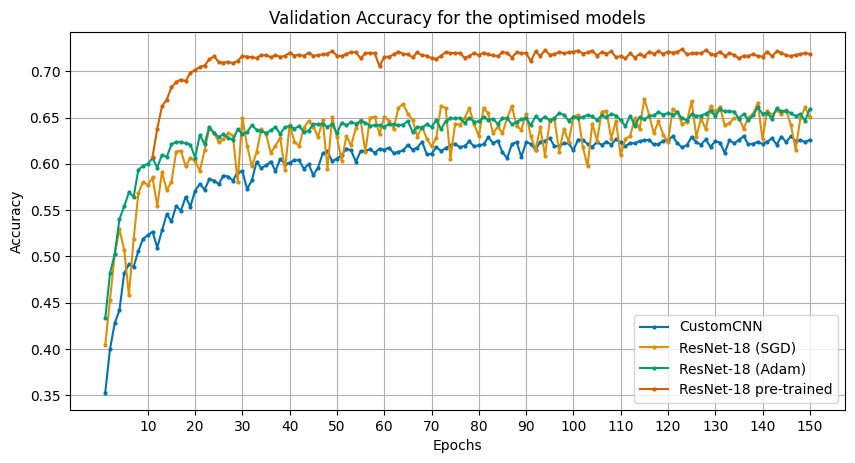

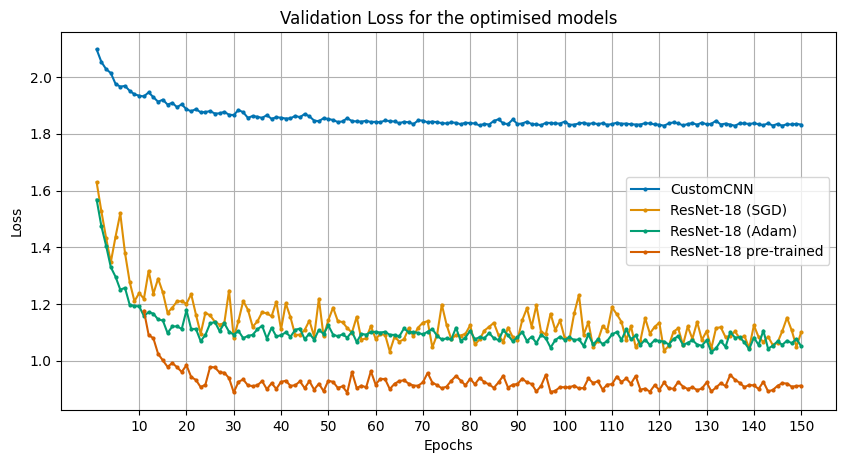

In [230]:
x_vals = list(range(1, len(stats_best_custom['valid_accuracy']) + 1))
x_vals_r_pretrained = list(range(11, len(stats_best_custom['valid_accuracy']) + 1))
x_labels = list(range(10, len(stats_best_custom['valid_accuracy']) + 1, 10))
marker_size = 2

# Plot accuracy
sns.set_palette("colorblind")
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(x_vals, stats_best_custom['valid_accuracy'], label='CustomCNN', marker='o', markersize=marker_size)
plt.plot(x_vals, stats_best_resnet_sgd['valid_accuracy'], label='ResNet-18 (SGD)', marker='o', markersize=marker_size)
plt.plot(x_vals, stats_best_resnet_adam['valid_accuracy'], label='ResNet-18 (Adam)', marker='o', markersize=marker_size)
plt.plot(x_vals_r_pretrained, stats_best_resnet_pretrained['valid_accuracy'], label='ResNet-18 pre-trained', marker='o', markersize=marker_size)
plt.title('Validation Accuracy for the optimised models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(x_labels)
plt.grid(True)  # Add grid
plt.show()

# Plot validation loss
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(x_vals, stats_best_custom['valid_loss'], label='CustomCNN', marker='o', markersize=marker_size)
plt.plot(x_vals, stats_best_resnet_sgd['valid_loss'], label='ResNet-18 (SGD)', marker='o', markersize=marker_size)
plt.plot(x_vals, stats_best_resnet_adam['valid_loss'], label='ResNet-18 (Adam)', marker='o', markersize=marker_size)
plt.plot(x_vals_r_pretrained, stats_best_resnet_pretrained['valid_loss'], label='ResNet-18 pre-trained', marker='o', markersize=marker_size)
plt.title('Validation Loss for the optimised models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(x_labels)
plt.grid(True)  # Add grid
plt.show()

# 5. Ensembling

In [182]:
class Ensembling:
    def __init__(self, networks: list[nn.Module]) -> None:
        self.networks = networks

    def eval(self):
        for network in self.networks:
            network.eval()

In [183]:
class SoftVoting(Ensembling):
    
    def __call__(self, images: torch.Tensor) -> torch.Tensor:
        # make predictions
        predictions = []
        for network in self.networks:
            pred = network(images)
            pred = torch.softmax(pred, dim=1)
            
            predictions.append(pred)

        final_proba = torch.mean(torch.stack(predictions), dim=0)
        pred_labels = torch.argmax(final_proba, dim=1)
        return pred_labels

In [187]:
class HardVoting(Ensembling):
    
    def __call__(self, images: torch.Tensor) -> torch.Tensor:
        # make predictions
        predictions = torch.zeros(images.size(0), len(self.networks)).to(device)
        predictions_probs = torch.zeros(images.size(0), len(self.networks)).to(device)

        for i, network in enumerate(self.networks):
            pred = network(images)
            pred = torch.softmax(pred, dim=1)
            
            pred_labels = torch.argmax(pred, dim=1)
            predictions[:, i] = pred_labels
            predictions_probs[:, i] = torch.max(pred, dim=1)[0]
        
        ## if tied, mode returns the smallest value of the chosen labels
        final_pred_labels, _ = torch.mode(predictions, dim=1)
        # check if tied
        mode_counts = torch.sum(predictions.transpose(-1, 0) == final_pred_labels, dim=0)
        # if tied, return a label with the highest predicted probability
        final_pred_labels[mode_counts == 1] = predictions[torch.arange(len(predictions)), torch.argmax(predictions_probs, dim=1)][mode_counts == 1]
        return final_pred_labels

In [188]:
def calculate_accuracy(predictor: nn.Module | Ensembling, dataset: torch.Tensor, n_classes: int, verbose=True):
    """
    Returns:
        Total accuracy, accuracy per class
    """
    batch_size = 1000
    photos_processed = 0
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    predictor.eval()

    true_counts_per_class = torch.zeros(n_classes)
    class_counts = torch.zeros(n_classes)

    with torch.no_grad():
        for images, true_labels in data_loader:
            images = images.to(device)
            true_labels = true_labels.to(device)

            pred = predictor(images)
            if len(pred.shape) == 2:
                pred = torch.argmax(pred, dim=1)

            for label in range(n_classes):
                preds_for_class = pred[true_labels == label]
                class_counts[label] += len(true_labels[true_labels == label])
                true_counts_per_class[label] += int(torch.sum(preds_for_class == label))

            if verbose:
                photos_processed += batch_size
                print(f'processed {photos_processed} photos')


    accuracy_per_class = (true_counts_per_class / class_counts).tolist()
    accuracy_total = float(true_counts_per_class.sum() / class_counts.sum())
    
    return accuracy_total, accuracy_per_class


## Testing the impact of ensembling. Choosing the final model

In [210]:
import pandas as pd

In [211]:
test_dataset = ImageFolder('data/test', transform=simple_load)

In [212]:
networks = [model_best_custom, model_best_resnet_sgd, model_best_resnet_adam]
soft_voting = SoftVoting(networks)
hard_voting = HardVoting(networks)

all_predictors = {
    'CustomCNN': model_best_custom,
    'ResNet-18 SGD': model_best_resnet_sgd,
    'ResNet-18 Adam': model_best_resnet_adam,
    'Soft Voting': soft_voting,
    'Hard Voting': hard_voting,
}

In [213]:
results_df = pd.DataFrame(columns=['Predictor', 'Class', 'Test Accuracy'])

for predictor_name, predictor in all_predictors.items():
    print(f'Processing {predictor_name}...')
    acc_total, acc_per_class = calculate_accuracy(predictor, test_dataset, n_classes=10)
    for class_name, class_acc in zip(test_dataset.classes, acc_per_class):
        results_df.loc[len(results_df.index)] = [predictor_name, class_name, class_acc]
    results_df.loc[len(results_df.index)] = [predictor_name, 'Total', acc_total]

Processing CustomCNN...


processed 1000 photos
processed 2000 photos
processed 3000 photos
processed 4000 photos
processed 5000 photos
processed 6000 photos
processed 7000 photos
processed 8000 photos
processed 9000 photos
processed 10000 photos
processed 11000 photos
processed 12000 photos
processed 13000 photos
processed 14000 photos
processed 15000 photos
processed 16000 photos
processed 17000 photos
processed 18000 photos
processed 19000 photos
processed 20000 photos
processed 21000 photos
processed 22000 photos
processed 23000 photos
processed 24000 photos
processed 25000 photos
processed 26000 photos
processed 27000 photos
processed 28000 photos
processed 29000 photos
processed 30000 photos
processed 31000 photos
processed 32000 photos
processed 33000 photos
processed 34000 photos
processed 35000 photos
processed 36000 photos
processed 37000 photos
processed 38000 photos
processed 39000 photos
processed 40000 photos
processed 41000 photos
processed 42000 photos
processed 43000 photos
processed 44000 phot

In [214]:
results_df.to_csv('./saved/final_results.csv', index=False)

In [215]:
results_df = pd.read_csv('./saved/final_results.csv')

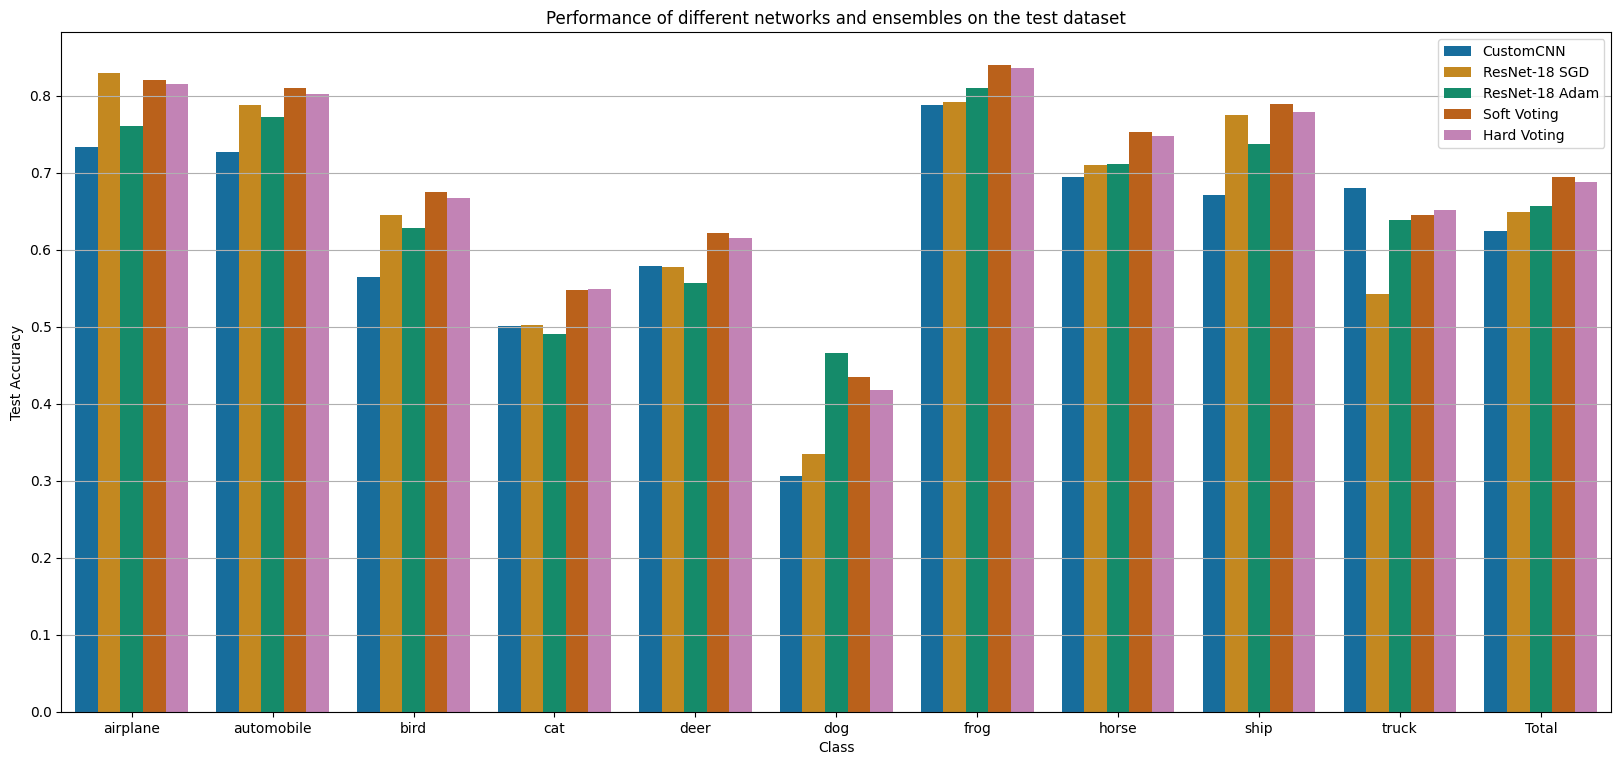

In [216]:
plt.figure(figsize=(20, 9), dpi=100)
sns.barplot(
    data=results_df,
    x='Class',
    y='Test Accuracy',
    hue='Predictor',
    palette='colorblind',
)
plt.legend()
plt.grid(True, axis='y')
plt.title('Performance of different networks and ensembles on the test dataset')
plt.show()

In [217]:
results_df[results_df['Class'] == 'Total']\
    .sort_values('Test Accuracy', ascending=False)\
    .reset_index(drop=True)

,Predictor,Class,Test Accuracy
0,Soft Voting,Total,0.693633
1,Hard Voting,Total,0.687656
2,ResNet-18 Adam,Total,0.656967
3,ResNet-18 SGD,Total,0.649411
4,CustomCNN,Total,0.624289
